In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numerapi import NumerAPI

# import kmeans from sklearn
from sklearn.cluster import KMeans

np.random.seed(42)
napi = NumerAPI()


In [17]:
napi.download_dataset("numerai_training_data.parquet", "data/numerai_training_data.parquet")
trainset = pd.read_parquet("data/numerai_training_data.parquet")
feature_names = [f for f in trainset.columns if "feature_" in f]

2022-01-07 17:43:43,733 INFO numerapi.utils: target file already exists
2022-01-07 17:43:43,734 INFO numerapi.utils: download complete


After the release of the new dataset feature groups went away, making it more difficult to work with.
Feature groups similar to the old data can be recreated using k-means clustering.
Below is a correlation matrix of the new dataset. The only decernable pattern here is that every ~200 features is similar in some way.

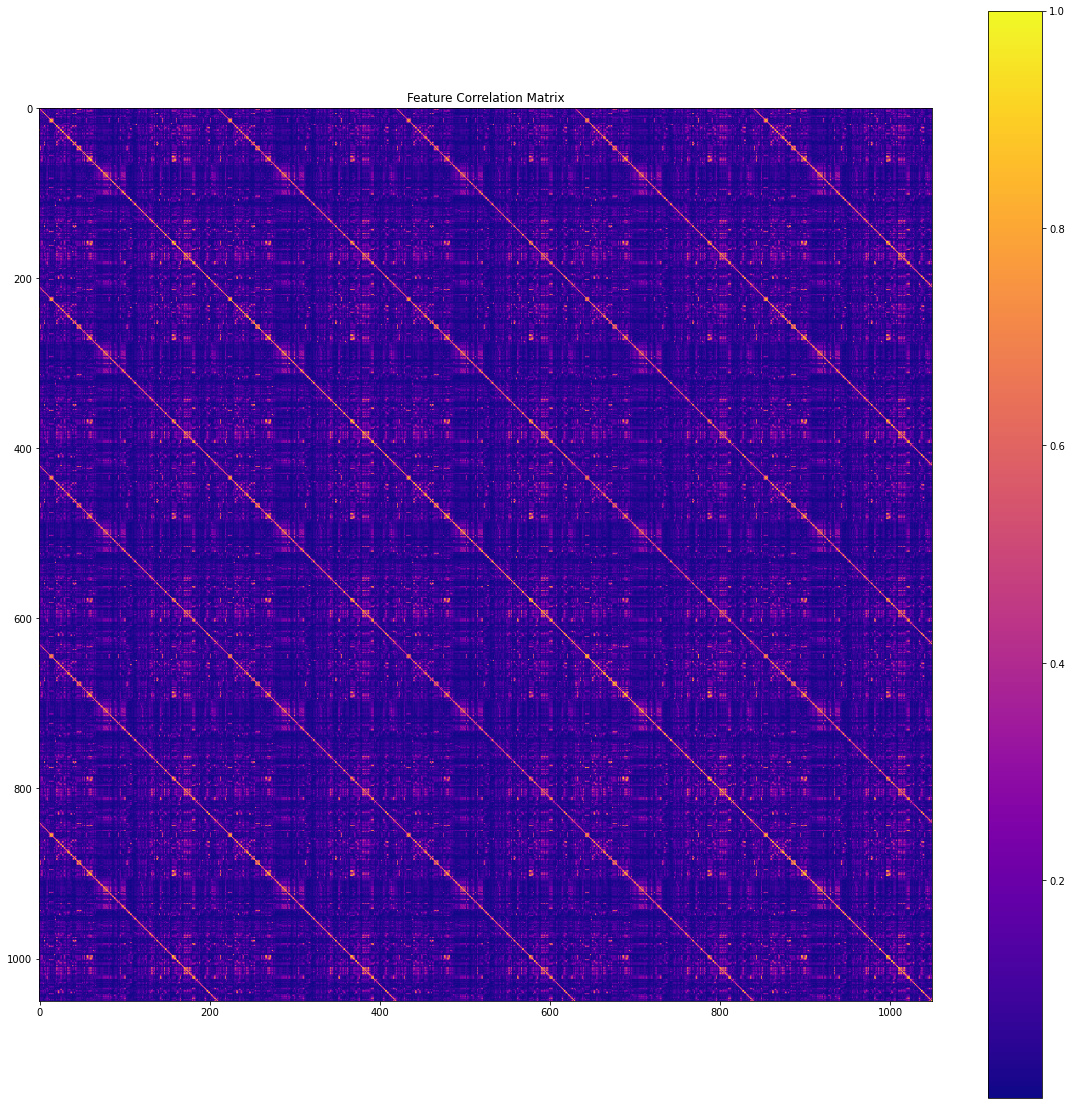

In [18]:
# generate feature correlation matrix
# use 10000 rows to reduce computation time
all_feature_corrs = trainset[feature_names].sample(10000 ,random_state = 0).corr()

# take the absolute value of the correlation matrix. 
# inveresely correlated features are assumed to be related.
all_feature_corrs = all_feature_corrs.abs()

#plot correlation matrix
plt.figure(figsize=(20,20))
fig = plt.imshow(all_feature_corrs)
plt.title("Feature Correlation Matrix")
plt.plasma()
plt.colorbar(fig)
plt.show()


We can use k-means clustering on the columns of the correlation matrix to cluster them together.
Each column shows how a given feature is correlated with all of the others.
We want 2 features with similar columns to be in the same group.

In [19]:
# cluster all feature corrs using kmeans into clusters
N_CLUSTERS = 24
kmeans = KMeans(n_clusters=N_CLUSTERS)
kmeans.fit(np.transpose(all_feature_corrs.values))
print(kmeans.labels_.shape)

# list of lists of feature names
feature_groups = []
for i in range(N_CLUSTERS):
    feature_group = []
    for j, name in enumerate(feature_names):
        if kmeans.labels_[j] == i:
            feature_group.append(name)

    feature_groups.append(feature_group)

# concatenate all feature groups into one list, effectively ordering them by group
ordered_feature_names = []
for i, group in enumerate(feature_groups):
    ordered_feature_names = ordered_feature_names + group

(1050,)


The new feature groups can be visualized by reordering columns in the dataset by group, and recalculating its correlation matrix.
The bright squares along the diagonal of the matrix below show the new groups and how features interact within them.

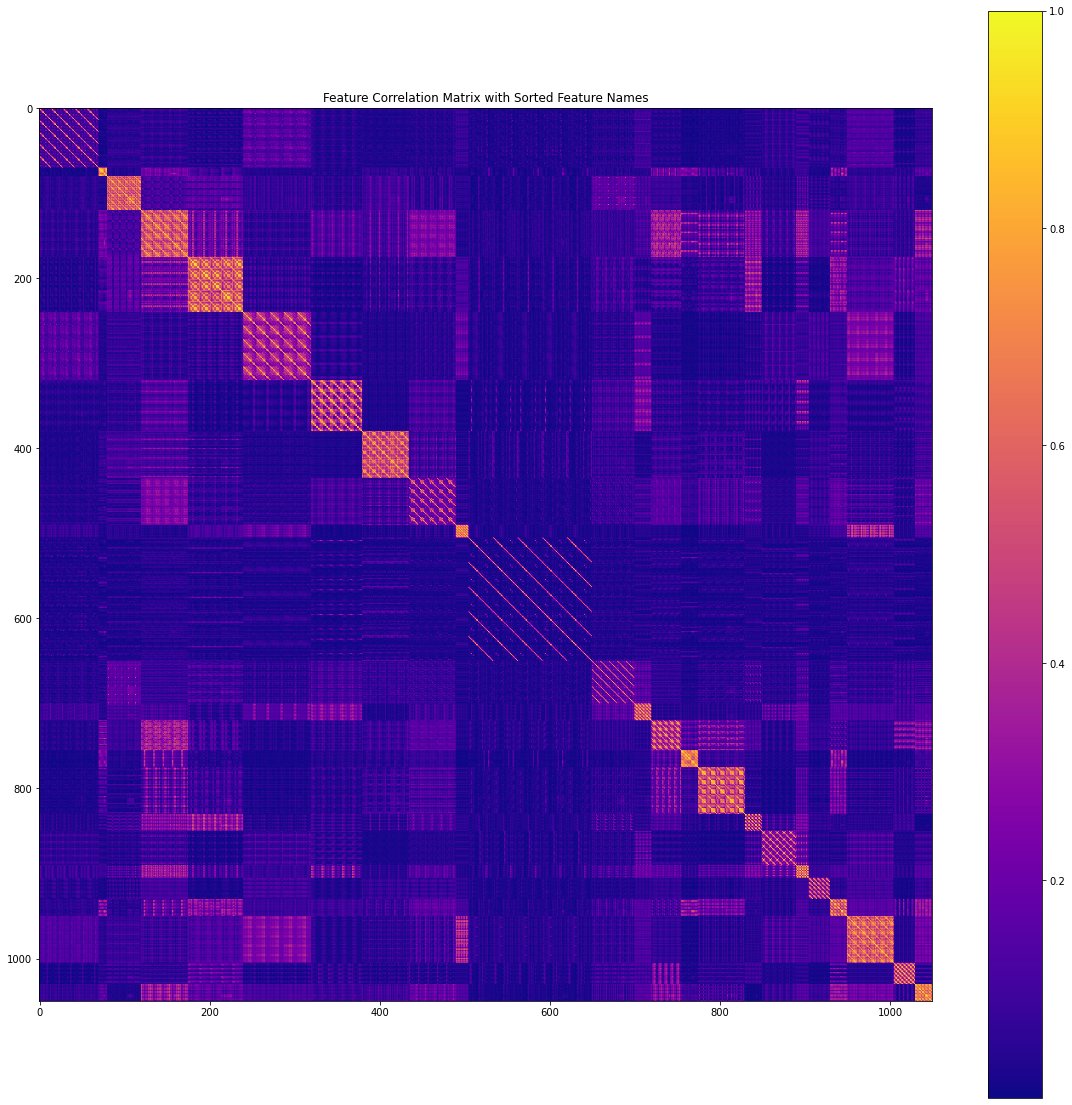

In [20]:
# generate feature correlation matrix with a now ordered feature list
# use 10000 rows to reduce computation time
ordered_feature_corrs = trainset[ordered_feature_names].sample(10000 ,random_state = 0).corr()
ordered_feature_corrs = ordered_feature_corrs.abs()

#plot correlation matrix
plt.figure(figsize=(20,20))
fig = plt.imshow(ordered_feature_corrs)
plt.title("Feature Correlation Matrix with Sorted Feature Names")
plt.plasma()
plt.colorbar(fig)
plt.show()

Notice that the repeating pattern seen in the original correlation matrix shows up in each group.
We can do better by repeating this method recursively. Basically finding sub groups within the new groups.

<img src="https://external-content.duckduckgo.com/iu/?u=http%3A%2F%2Ffc02.deviantart.net%2Ffs70%2Ff%2F2012%2F220%2F5%2Fe%2Fxzibit_yo_dawg_render_by_kernelpanicx-d5aa710.png&f=1&nofb=1">

In [21]:
# generate feature groups. then recursivly generate feature groups with the new feature groups
def recursive_feature_grouping(df, feature_names, n_clusters, depth = 1):
    if depth == 0 or len(feature_names) <= n_clusters:
        return feature_names

    # cluster all feature corrs using kmeans into clusters
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(df[feature_names].corr().abs().values)

    feature_groups = []
    for i in range(n_clusters):
        feature_group = []
        for j, name in enumerate(feature_names):
            if kmeans.labels_[j] == i:
                feature_group.append(name)

        feature_groups.append(
            recursive_feature_grouping(df, feature_group, n_clusters, depth=depth-1,)
        )

    return feature_groups

# turn nested list (tree) into reordered feature list like before
def tree_to_list(tree):
    output_list = []

    def traverse(node):
        if isinstance(node, list):
            for item in node:
                traverse(item)
        else:
            output_list.append(node)

    traverse(tree)

    return output_list

feature_tree = recursive_feature_grouping(
    trainset.sample(10000), feature_names, n_clusters=5, depth=6
)
ordered_feature_names = tree_to_list(feature_tree)

The recursive method produces a more interesting looking correlation matrix

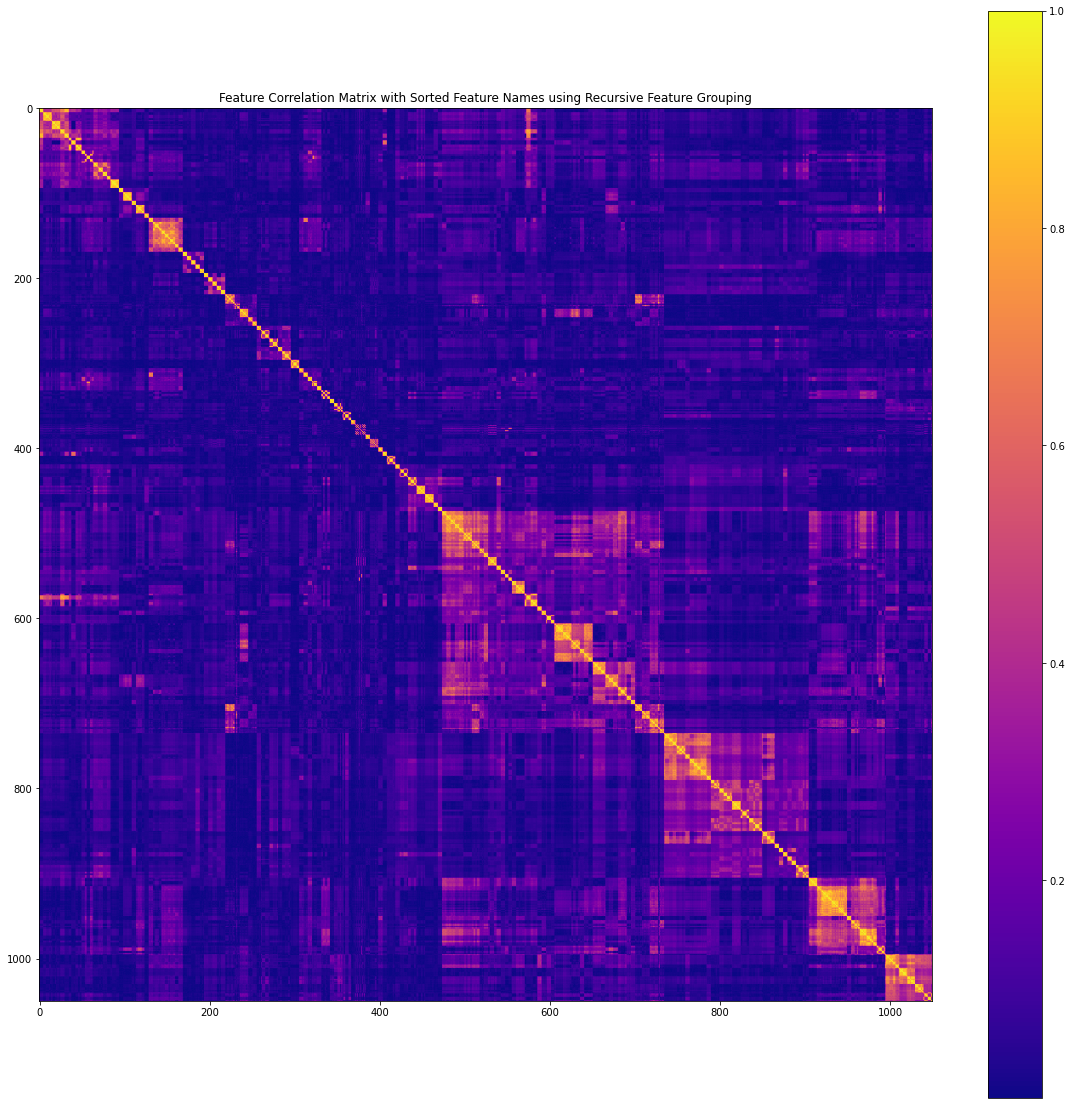

In [22]:
# generate feature correlation matrix with a now ordered feature list
# use 10000 rows to reduce computation time

ordered_feature_corrs = trainset[ordered_feature_names].sample(10000 ,random_state = 0).corr()
ordered_feature_corrs = ordered_feature_corrs.abs()
plt.figure(figsize=(20,20))
fig = plt.imshow(ordered_feature_corrs)
plt.title("Feature Correlation Matrix with Sorted Feature Names using Recursive Feature Grouping")
plt.plasma()
plt.colorbar(fig)
plt.show()

Below is code for turning the nested list of groups (tree) into a dataframe.

In [23]:
# return df with feature names, and thier path in the tree
# holy recursion, batman!
def tree_to_df(tree, n_clusters):
    df = pd.DataFrame({
        "feature_names": tree_to_list(tree)
    }).set_index("feature_names")
    
    # records the path of each feature in the tree
    path = []

    def traverse(node, depth = 0):
        if isinstance(node, list):
            for i, item in enumerate(node):
                path.append(i)
                traverse(item, depth+1)
                path.pop()
        else:
            # in this case node is a feature name (leaf)
            for i, item in enumerate(path):
                col_name = "depth_{}".format(i+1)
                if col_name not in df.columns:
                    df[col_name] = np.nan
                df.loc[node, col_name] = item
    traverse(tree)

    depth_cols = [c for c in df.columns if "depth_" in c]
    
    # prune columns with nans
    for col in depth_cols:
        if df[col].isnull().max():
            df.drop(col, axis=1, inplace=True)
        
    depth_cols = [c for c in df.columns if "depth_" in c]

    # give each group a number according to its path in the tree
    for i, c in enumerate(depth_cols):
        df[c] = df[c].astype(int)
        if i < len(depth_cols) - 1:
            df[depth_cols[i+1]] = (df[c] * n_clusters) + df[depth_cols[i+1]]

    # add 1 to every element
    for i, c in enumerate(depth_cols):
        df[c] = df[c] + 1

    return df

group_df = tree_to_df(feature_tree, n_clusters=5)
group_df.to_csv("feature_groups.csv")
tree_to_df(feature_tree, n_clusters=5)

depth_1  depth_2  depth_3  depth_4
feature_names                                                                 
feature_generative_honorific_tughrik              1        1        1        1
feature_biased_puzzling_cessation                 1        1        1        1
feature_sludgiest_telltale_mutant                 1        1        1        1
feature_palatalized_unsucceeded_induration        1        1        1        1
feature_fishiest_simulatory_roadholding           1        1        1        1
...                                             ...      ...      ...      ...
feature_coalier_typhoid_muntin                    5       25      124      616
feature_bold_brindle_playground                   5       25      124      617
feature_mailed_harried_grant                      5       25      124      618
feature_forworn_hask_haet                         5       25      124      619
feature_illiterate_stomachal_terpene              5       25      125      621

[1050 rows x 4 columns]

Feature groups get more granular at each depth

In [24]:
# visualize feature groups at various depths

import plotly.express as px
import plotly.io as pio
pio.renderers.default='notebook'

depth_cols = [c for c in group_df.columns if "depth_" in c]
for col in depth_cols:
    group_df[col] = (len(group_df) / (group_df[col].max() + 1)) * (group_df[col] + 1)
    group_df[col] = group_df[col].astype(int)

group_df.head()

fig = px.imshow(group_df, aspect='auto', color_continuous_scale=px.colors.sequential.Turbo)
fig.show()


In [25]:
%%js
/** vim: et:ts=4:sw=4:sts=4
 * @license RequireJS 2.3.6 Copyright jQuery Foundation and other contributors.
 * Released under MIT license, https://github.com/requirejs/requirejs/blob/master/LICENSE
 */
var requirejs,require,define;!function(global,setTimeout){var req,s,head,baseElement,dataMain,src,interactiveScript,currentlyAddingScript,mainScript,subPath,version="2.3.6",commentRegExp=/\/\*[\s\S]*?\*\/|([^:"'=]|^)\/\/.*$/gm,cjsRequireRegExp=/[^.]\s*require\s*\(\s*["']([^'"\s]+)["']\s*\)/g,jsSuffixRegExp=/\.js$/,currDirRegExp=/^\.\//,op=Object.prototype,ostring=op.toString,hasOwn=op.hasOwnProperty,isBrowser=!("undefined"==typeof window||"undefined"==typeof navigator||!window.document),isWebWorker=!isBrowser&&"undefined"!=typeof importScripts,readyRegExp=isBrowser&&"PLAYSTATION 3"===navigator.platform?/^complete$/:/^(complete|loaded)$/,defContextName="_",isOpera="undefined"!=typeof opera&&"[object Opera]"===opera.toString(),contexts={},cfg={},globalDefQueue=[],useInteractive=!1;function commentReplace(e,t){return t||""}function isFunction(e){return"[object Function]"===ostring.call(e)}function isArray(e){return"[object Array]"===ostring.call(e)}function each(e,t){var i;if(e)for(i=0;i<e.length&&(!e[i]||!t(e[i],i,e));i+=1);}function eachReverse(e,t){var i;if(e)for(i=e.length-1;-1<i&&(!e[i]||!t(e[i],i,e));i-=1);}function hasProp(e,t){return hasOwn.call(e,t)}function getOwn(e,t){return hasProp(e,t)&&e[t]}function eachProp(e,t){var i;for(i in e)if(hasProp(e,i)&&t(e[i],i))break}function mixin(i,e,r,n){return e&&eachProp(e,function(e,t){!r&&hasProp(i,t)||(!n||"object"!=typeof e||!e||isArray(e)||isFunction(e)||e instanceof RegExp?i[t]=e:(i[t]||(i[t]={}),mixin(i[t],e,r,n)))}),i}function bind(e,t){return function(){return t.apply(e,arguments)}}function scripts(){return document.getElementsByTagName("script")}function defaultOnError(e){throw e}function getGlobal(e){if(!e)return e;var t=global;return each(e.split("."),function(e){t=t[e]}),t}function makeError(e,t,i,r){var n=new Error(t+"\nhttps://requirejs.org/docs/errors.html#"+e);return n.requireType=e,n.requireModules=r,i&&(n.originalError=i),n}if(void 0===define){if(void 0!==requirejs){if(isFunction(requirejs))return;cfg=requirejs,requirejs=void 0}void 0===require||isFunction(require)||(cfg=require,require=void 0),req=requirejs=function(e,t,i,r){var n,o,a=defContextName;return isArray(e)||"string"==typeof e||(o=e,isArray(t)?(e=t,t=i,i=r):e=[]),o&&o.context&&(a=o.context),(n=getOwn(contexts,a))||(n=contexts[a]=req.s.newContext(a)),o&&n.configure(o),n.require(e,t,i)},req.config=function(e){return req(e)},req.nextTick=void 0!==setTimeout?function(e){setTimeout(e,4)}:function(e){e()},require||(require=req),req.version=version,req.jsExtRegExp=/^\/|:|\?|\.js$/,req.isBrowser=isBrowser,s=req.s={contexts:contexts,newContext:newContext},req({}),each(["toUrl","undef","defined","specified"],function(t){req[t]=function(){var e=contexts[defContextName];return e.require[t].apply(e,arguments)}}),isBrowser&&(head=s.head=document.getElementsByTagName("head")[0],baseElement=document.getElementsByTagName("base")[0],baseElement&&(head=s.head=baseElement.parentNode)),req.onError=defaultOnError,req.createNode=function(e,t,i){var r=e.xhtml?document.createElementNS("http://www.w3.org/1999/xhtml","html:script"):document.createElement("script");return r.type=e.scriptType||"text/javascript",r.charset="utf-8",r.async=!0,r},req.load=function(t,i,r){var e,n=t&&t.config||{};if(isBrowser)return(e=req.createNode(n,i,r)).setAttribute("data-requirecontext",t.contextName),e.setAttribute("data-requiremodule",i),!e.attachEvent||e.attachEvent.toString&&e.attachEvent.toString().indexOf("[native code")<0||isOpera?(e.addEventListener("load",t.onScriptLoad,!1),e.addEventListener("error",t.onScriptError,!1)):(useInteractive=!0,e.attachEvent("onreadystatechange",t.onScriptLoad)),e.src=r,n.onNodeCreated&&n.onNodeCreated(e,n,i,r),currentlyAddingScript=e,baseElement?head.insertBefore(e,baseElement):head.appendChild(e),currentlyAddingScript=null,e;if(isWebWorker)try{setTimeout(function(){},0),importScripts(r),t.completeLoad(i)}catch(e){t.onError(makeError("importscripts","importScripts failed for "+i+" at "+r,e,[i]))}},isBrowser&&!cfg.skipDataMain&&eachReverse(scripts(),function(e){if(head||(head=e.parentNode),dataMain=e.getAttribute("data-main"))return mainScript=dataMain,cfg.baseUrl||-1!==mainScript.indexOf("!")||(mainScript=(src=mainScript.split("/")).pop(),subPath=src.length?src.join("/")+"/":"./",cfg.baseUrl=subPath),mainScript=mainScript.replace(jsSuffixRegExp,""),req.jsExtRegExp.test(mainScript)&&(mainScript=dataMain),cfg.deps=cfg.deps?cfg.deps.concat(mainScript):[mainScript],!0}),define=function(e,i,t){var r,n;"string"!=typeof e&&(t=i,i=e,e=null),isArray(i)||(t=i,i=null),!i&&isFunction(t)&&(i=[],t.length&&(t.toString().replace(commentRegExp,commentReplace).replace(cjsRequireRegExp,function(e,t){i.push(t)}),i=(1===t.length?["require"]:["require","exports","module"]).concat(i))),useInteractive&&(r=currentlyAddingScript||getInteractiveScript())&&(e||(e=r.getAttribute("data-requiremodule")),n=contexts[r.getAttribute("data-requirecontext")]),n?(n.defQueue.push([e,i,t]),n.defQueueMap[e]=!0):globalDefQueue.push([e,i,t])},define.amd={jQuery:!0},req.exec=function(text){return eval(text)},req(cfg)}function newContext(u){var i,e,l,c,d,g={waitSeconds:7,baseUrl:"./",paths:{},bundles:{},pkgs:{},shim:{},config:{}},p={},f={},r={},h=[],m={},n={},v={},x=1,b=1;function q(e,t,i){var r,n,o,a,s,u,c,d,p,f,l=t&&t.split("/"),h=g.map,m=h&&h["*"];if(e&&(u=(e=e.split("/")).length-1,g.nodeIdCompat&&jsSuffixRegExp.test(e[u])&&(e[u]=e[u].replace(jsSuffixRegExp,"")),"."===e[0].charAt(0)&&l&&(e=l.slice(0,l.length-1).concat(e)),function(e){var t,i;for(t=0;t<e.length;t++)if("."===(i=e[t]))e.splice(t,1),t-=1;else if(".."===i){if(0===t||1===t&&".."===e[2]||".."===e[t-1])continue;0<t&&(e.splice(t-1,2),t-=2)}}(e),e=e.join("/")),i&&h&&(l||m)){e:for(o=(n=e.split("/")).length;0<o;o-=1){if(s=n.slice(0,o).join("/"),l)for(a=l.length;0<a;a-=1)if((r=getOwn(h,l.slice(0,a).join("/")))&&(r=getOwn(r,s))){c=r,d=o;break e}!p&&m&&getOwn(m,s)&&(p=getOwn(m,s),f=o)}!c&&p&&(c=p,d=f),c&&(n.splice(0,d,c),e=n.join("/"))}return getOwn(g.pkgs,e)||e}function E(t){isBrowser&&each(scripts(),function(e){if(e.getAttribute("data-requiremodule")===t&&e.getAttribute("data-requirecontext")===l.contextName)return e.parentNode.removeChild(e),!0})}function w(e){var t=getOwn(g.paths,e);if(t&&isArray(t)&&1<t.length)return t.shift(),l.require.undef(e),l.makeRequire(null,{skipMap:!0})([e]),!0}function y(e){var t,i=e?e.indexOf("!"):-1;return-1<i&&(t=e.substring(0,i),e=e.substring(i+1,e.length)),[t,e]}function S(e,t,i,r){var n,o,a,s,u=null,c=t?t.name:null,d=e,p=!0,f="";return e||(p=!1,e="_@r"+(x+=1)),u=(s=y(e))[0],e=s[1],u&&(u=q(u,c,r),o=getOwn(m,u)),e&&(u?f=i?e:o&&o.normalize?o.normalize(e,function(e){return q(e,c,r)}):-1===e.indexOf("!")?q(e,c,r):e:(u=(s=y(f=q(e,c,r)))[0],f=s[1],i=!0,n=l.nameToUrl(f))),{prefix:u,name:f,parentMap:t,unnormalized:!!(a=!u||o||i?"":"_unnormalized"+(b+=1)),url:n,originalName:d,isDefine:p,id:(u?u+"!"+f:f)+a}}function k(e){var t=e.id,i=getOwn(p,t);return i||(i=p[t]=new l.Module(e)),i}function M(e,t,i){var r=e.id,n=getOwn(p,r);!hasProp(m,r)||n&&!n.defineEmitComplete?(n=k(e)).error&&"error"===t?i(n.error):n.on(t,i):"defined"===t&&i(m[r])}function O(i,e){var t=i.requireModules,r=!1;e?e(i):(each(t,function(e){var t=getOwn(p,e);t&&(t.error=i,t.events.error&&(r=!0,t.emit("error",i)))}),r||req.onError(i))}function j(){globalDefQueue.length&&(each(globalDefQueue,function(e){var t=e[0];"string"==typeof t&&(l.defQueueMap[t]=!0),h.push(e)}),globalDefQueue=[])}function P(e){delete p[e],delete f[e]}function R(){var e,r,t=1e3*g.waitSeconds,n=t&&l.startTime+t<(new Date).getTime(),o=[],a=[],s=!1,u=!0;if(!i){if(i=!0,eachProp(f,function(e){var t=e.map,i=t.id;if(e.enabled&&(t.isDefine||a.push(e),!e.error))if(!e.inited&&n)w(i)?s=r=!0:(o.push(i),E(i));else if(!e.inited&&e.fetched&&t.isDefine&&(s=!0,!t.prefix))return u=!1}),n&&o.length)return(e=makeError("timeout","Load timeout for modules: "+o,null,o)).contextName=l.contextName,O(e);u&&each(a,function(e){!function n(o,a,s){var e=o.map.id;o.error?o.emit("error",o.error):(a[e]=!0,each(o.depMaps,function(e,t){var i=e.id,r=getOwn(p,i);!r||o.depMatched[t]||s[i]||(getOwn(a,i)?(o.defineDep(t,m[i]),o.check()):n(r,a,s))}),s[e]=!0)}(e,{},{})}),n&&!r||!s||!isBrowser&&!isWebWorker||d||(d=setTimeout(function(){d=0,R()},50)),i=!1}}function a(e){hasProp(m,e[0])||k(S(e[0],null,!0)).init(e[1],e[2])}function o(e,t,i,r){e.detachEvent&&!isOpera?r&&e.detachEvent(r,t):e.removeEventListener(i,t,!1)}function s(e){var t=e.currentTarget||e.srcElement;return o(t,l.onScriptLoad,"load","onreadystatechange"),o(t,l.onScriptError,"error"),{node:t,id:t&&t.getAttribute("data-requiremodule")}}function T(){var e;for(j();h.length;){if(null===(e=h.shift())[0])return O(makeError("mismatch","Mismatched anonymous define() module: "+e[e.length-1]));a(e)}l.defQueueMap={}}return c={require:function(e){return e.require?e.require:e.require=l.makeRequire(e.map)},exports:function(e){if(e.usingExports=!0,e.map.isDefine)return e.exports?m[e.map.id]=e.exports:e.exports=m[e.map.id]={}},module:function(e){return e.module?e.module:e.module={id:e.map.id,uri:e.map.url,config:function(){return getOwn(g.config,e.map.id)||{}},exports:e.exports||(e.exports={})}}},(e=function(e){this.events=getOwn(r,e.id)||{},this.map=e,this.shim=getOwn(g.shim,e.id),this.depExports=[],this.depMaps=[],this.depMatched=[],this.pluginMaps={},this.depCount=0}).prototype={init:function(e,t,i,r){r=r||{},this.inited||(this.factory=t,i?this.on("error",i):this.events.error&&(i=bind(this,function(e){this.emit("error",e)})),this.depMaps=e&&e.slice(0),this.errback=i,this.inited=!0,this.ignore=r.ignore,r.enabled||this.enabled?this.enable():this.check())},defineDep:function(e,t){this.depMatched[e]||(this.depMatched[e]=!0,this.depCount-=1,this.depExports[e]=t)},fetch:function(){if(!this.fetched){this.fetched=!0,l.startTime=(new Date).getTime();var e=this.map;if(!this.shim)return e.prefix?this.callPlugin():this.load();l.makeRequire(this.map,{enableBuildCallback:!0})(this.shim.deps||[],bind(this,function(){return e.prefix?this.callPlugin():this.load()}))}},load:function(){var e=this.map.url;n[e]||(n[e]=!0,l.load(this.map.id,e))},check:function(){if(this.enabled&&!this.enabling){var t,e,i=this.map.id,r=this.depExports,n=this.exports,o=this.factory;if(this.inited){if(this.error)this.emit("error",this.error);else if(!this.defining){if(this.defining=!0,this.depCount<1&&!this.defined){if(isFunction(o)){if(this.events.error&&this.map.isDefine||req.onError!==defaultOnError)try{n=l.execCb(i,o,r,n)}catch(e){t=e}else n=l.execCb(i,o,r,n);if(this.map.isDefine&&void 0===n&&((e=this.module)?n=e.exports:this.usingExports&&(n=this.exports)),t)return t.requireMap=this.map,t.requireModules=this.map.isDefine?[this.map.id]:null,t.requireType=this.map.isDefine?"define":"require",O(this.error=t)}else n=o;if(this.exports=n,this.map.isDefine&&!this.ignore&&(m[i]=n,req.onResourceLoad)){var a=[];each(this.depMaps,function(e){a.push(e.normalizedMap||e)}),req.onResourceLoad(l,this.map,a)}P(i),this.defined=!0}this.defining=!1,this.defined&&!this.defineEmitted&&(this.defineEmitted=!0,this.emit("defined",this.exports),this.defineEmitComplete=!0)}}else hasProp(l.defQueueMap,i)||this.fetch()}},callPlugin:function(){var u=this.map,c=u.id,e=S(u.prefix);this.depMaps.push(e),M(e,"defined",bind(this,function(e){var o,t,i,r=getOwn(v,this.map.id),n=this.map.name,a=this.map.parentMap?this.map.parentMap.name:null,s=l.makeRequire(u.parentMap,{enableBuildCallback:!0});return this.map.unnormalized?(e.normalize&&(n=e.normalize(n,function(e){return q(e,a,!0)})||""),M(t=S(u.prefix+"!"+n,this.map.parentMap,!0),"defined",bind(this,function(e){this.map.normalizedMap=t,this.init([],function(){return e},null,{enabled:!0,ignore:!0})})),void((i=getOwn(p,t.id))&&(this.depMaps.push(t),this.events.error&&i.on("error",bind(this,function(e){this.emit("error",e)})),i.enable()))):r?(this.map.url=l.nameToUrl(r),void this.load()):((o=bind(this,function(e){this.init([],function(){return e},null,{enabled:!0})})).error=bind(this,function(e){this.inited=!0,(this.error=e).requireModules=[c],eachProp(p,function(e){0===e.map.id.indexOf(c+"_unnormalized")&&P(e.map.id)}),O(e)}),o.fromText=bind(this,function(e,t){var i=u.name,r=S(i),n=useInteractive;t&&(e=t),n&&(useInteractive=!1),k(r),hasProp(g.config,c)&&(g.config[i]=g.config[c]);try{req.exec(e)}catch(e){return O(makeError("fromtexteval","fromText eval for "+c+" failed: "+e,e,[c]))}n&&(useInteractive=!0),this.depMaps.push(r),l.completeLoad(i),s([i],o)}),void e.load(u.name,s,o,g))})),l.enable(e,this),this.pluginMaps[e.id]=e},enable:function(){(f[this.map.id]=this).enabled=!0,this.enabling=!0,each(this.depMaps,bind(this,function(e,t){var i,r,n;if("string"==typeof e){if(e=S(e,this.map.isDefine?this.map:this.map.parentMap,!1,!this.skipMap),this.depMaps[t]=e,n=getOwn(c,e.id))return void(this.depExports[t]=n(this));this.depCount+=1,M(e,"defined",bind(this,function(e){this.undefed||(this.defineDep(t,e),this.check())})),this.errback?M(e,"error",bind(this,this.errback)):this.events.error&&M(e,"error",bind(this,function(e){this.emit("error",e)}))}i=e.id,r=p[i],hasProp(c,i)||!r||r.enabled||l.enable(e,this)})),eachProp(this.pluginMaps,bind(this,function(e){var t=getOwn(p,e.id);t&&!t.enabled&&l.enable(e,this)})),this.enabling=!1,this.check()},on:function(e,t){var i=this.events[e];i||(i=this.events[e]=[]),i.push(t)},emit:function(e,t){each(this.events[e],function(e){e(t)}),"error"===e&&delete this.events[e]}},(l={config:g,contextName:u,registry:p,defined:m,urlFetched:n,defQueue:h,defQueueMap:{},Module:e,makeModuleMap:S,nextTick:req.nextTick,onError:O,configure:function(e){if(e.baseUrl&&"/"!==e.baseUrl.charAt(e.baseUrl.length-1)&&(e.baseUrl+="/"),"string"==typeof e.urlArgs){var i=e.urlArgs;e.urlArgs=function(e,t){return(-1===t.indexOf("?")?"?":"&")+i}}var r=g.shim,n={paths:!0,bundles:!0,config:!0,map:!0};eachProp(e,function(e,t){n[t]?(g[t]||(g[t]={}),mixin(g[t],e,!0,!0)):g[t]=e}),e.bundles&&eachProp(e.bundles,function(e,t){each(e,function(e){e!==t&&(v[e]=t)})}),e.shim&&(eachProp(e.shim,function(e,t){isArray(e)&&(e={deps:e}),!e.exports&&!e.init||e.exportsFn||(e.exportsFn=l.makeShimExports(e)),r[t]=e}),g.shim=r),e.packages&&each(e.packages,function(e){var t;t=(e="string"==typeof e?{name:e}:e).name,e.location&&(g.paths[t]=e.location),g.pkgs[t]=e.name+"/"+(e.main||"main").replace(currDirRegExp,"").replace(jsSuffixRegExp,"")}),eachProp(p,function(e,t){e.inited||e.map.unnormalized||(e.map=S(t,null,!0))}),(e.deps||e.callback)&&l.require(e.deps||[],e.callback)},makeShimExports:function(t){return function(){var e;return t.init&&(e=t.init.apply(global,arguments)),e||t.exports&&getGlobal(t.exports)}},makeRequire:function(o,a){function s(e,t,i){var r,n;return a.enableBuildCallback&&t&&isFunction(t)&&(t.__requireJsBuild=!0),"string"==typeof e?isFunction(t)?O(makeError("requireargs","Invalid require call"),i):o&&hasProp(c,e)?c[e](p[o.id]):req.get?req.get(l,e,o,s):(r=S(e,o,!1,!0).id,hasProp(m,r)?m[r]:O(makeError("notloaded",'Module name "'+r+'" has not been loaded yet for context: '+u+(o?"":". Use require([])")))):(T(),l.nextTick(function(){T(),(n=k(S(null,o))).skipMap=a.skipMap,n.init(e,t,i,{enabled:!0}),R()}),s)}return a=a||{},mixin(s,{isBrowser:isBrowser,toUrl:function(e){var t,i=e.lastIndexOf("."),r=e.split("/")[0];return-1!==i&&(!("."===r||".."===r)||1<i)&&(t=e.substring(i,e.length),e=e.substring(0,i)),l.nameToUrl(q(e,o&&o.id,!0),t,!0)},defined:function(e){return hasProp(m,S(e,o,!1,!0).id)},specified:function(e){return e=S(e,o,!1,!0).id,hasProp(m,e)||hasProp(p,e)}}),o||(s.undef=function(i){j();var e=S(i,o,!0),t=getOwn(p,i);t.undefed=!0,E(i),delete m[i],delete n[e.url],delete r[i],eachReverse(h,function(e,t){e[0]===i&&h.splice(t,1)}),delete l.defQueueMap[i],t&&(t.events.defined&&(r[i]=t.events),P(i))}),s},enable:function(e){getOwn(p,e.id)&&k(e).enable()},completeLoad:function(e){var t,i,r,n=getOwn(g.shim,e)||{},o=n.exports;for(j();h.length;){if(null===(i=h.shift())[0]){if(i[0]=e,t)break;t=!0}else i[0]===e&&(t=!0);a(i)}if(l.defQueueMap={},r=getOwn(p,e),!t&&!hasProp(m,e)&&r&&!r.inited){if(!(!g.enforceDefine||o&&getGlobal(o)))return w(e)?void 0:O(makeError("nodefine","No define call for "+e,null,[e]));a([e,n.deps||[],n.exportsFn])}R()},nameToUrl:function(e,t,i){var r,n,o,a,s,u,c=getOwn(g.pkgs,e);if(c&&(e=c),u=getOwn(v,e))return l.nameToUrl(u,t,i);if(req.jsExtRegExp.test(e))a=e+(t||"");else{for(r=g.paths,o=(n=e.split("/")).length;0<o;o-=1)if(s=getOwn(r,n.slice(0,o).join("/"))){isArray(s)&&(s=s[0]),n.splice(0,o,s);break}a=n.join("/"),a=("/"===(a+=t||(/^data\:|^blob\:|\?/.test(a)||i?"":".js")).charAt(0)||a.match(/^[\w\+\.\-]+:/)?"":g.baseUrl)+a}return g.urlArgs&&!/^blob\:/.test(a)?a+g.urlArgs(e,a):a},load:function(e,t){req.load(l,e,t)},execCb:function(e,t,i,r){return t.apply(r,i)},onScriptLoad:function(e){if("load"===e.type||readyRegExp.test((e.currentTarget||e.srcElement).readyState)){interactiveScript=null;var t=s(e);l.completeLoad(t.id)}},onScriptError:function(e){var i=s(e);if(!w(i.id)){var r=[];return eachProp(p,function(e,t){0!==t.indexOf("_@r")&&each(e.depMaps,function(e){if(e.id===i.id)return r.push(t),!0})}),O(makeError("scripterror",'Script error for "'+i.id+(r.length?'", needed by: '+r.join(", "):'"'),e,[i.id]))}}}).require=l.makeRequire(),l}function getInteractiveScript(){return interactiveScript&&"interactive"===interactiveScript.readyState||eachReverse(scripts(),function(e){if("interactive"===e.readyState)return interactiveScript=e}),interactiveScript}}(this,"undefined"==typeof setTimeout?void 0:setTimeout);

<IPython.core.display.Javascript object>